# ML redshift prediction with RACS+SM using GPU.

---

## Python setup

First, we install and import the packages to be used

We will start with RAPIDS.ai to have access to GPU models.

Click the Runtime dropdown at the top of the page, then Change Runtime Type and confirm the instance type is GPU.
Check the output of !nvidia-smi to make sure you've been allocated a Tesla T4, P4, or P100.

In [ ]:
!nvidia-smi

Mon Jul 26 16:33:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 277, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 277 (delta 59), reused 40 (delta 20), pack-reused 171
Receiving objects: 100% (277/277), 80.66 KiB | 10.08 MiB/s, done.
Resolving deltas: 100% (121/121), done.
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla T4!
***********************************************************************



In [ ]:
# This will update the Colab environment and restart the kernel.  Don't run the next cell until you see the session crash.
!bash rapidsai-csp-utils/colab/update_gcc.sh
import os
os._exit(00)

Updating your Colab environment.  This will restart your kernel.  Don't Panic!
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 http://security.ubuntu.com/ubuntu bio

In [ ]:
# This will install CondaColab.  This will restart your kernel one last time.  Run this cell by itself and only run the next cell once you see the session crash.
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:38
🔁 Restarting kernel...


In [ ]:
# you can now run the rest of the cells as normal
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [ ]:
# Installing RAPIDS is now 'python rapidsai-csp-utils/colab/install_rapids.py <release> <packages>'
# The <release> options are 'stable' and 'nightly'.  Leaving it blank or adding any other words will default to stable.
# The <packages> option are default blank or 'core'.  By default, we install RAPIDSAI and BlazingSQL.  The 'core' option will install only RAPIDSAI and not include BlazingSQL, 
!python rapidsai-csp-utils/colab/install_rapids.py stable core
import os
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
os.environ['CONDA_PREFIX'] = '/usr/local'

Installing RAPIDS Stable 21.06
Starting the RAPIDS install on Colab.  This will take about 15 minutes.
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - cudatoolkit=11.0
    - gcsfs
    - llvmlite
    - openssl
    - python=3.7
    - rapids=21.06


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    abseil-cpp-20210324.0      |       h9c3ff4c_0        1011 KB  conda-forge
    aiohttp-3.7.4.post0        |   py37h5e8e339_0         625 KB  conda-forge
    anyio-3.3.0                |   py37h89c1867_0         146 KB  conda-forge
    argon2-cffi-20.1.0         |   py37h5e8e339_2          47 KB  conda-fo

In [ ]:
# !pip install BorutaShap

!pip install scikit-learn==0.23.2

!pip install "tune-sklearn>=0.2.1"
!pip install "scikit-optimize>=0.8.1"

!pip install ppscore

!pip install sklearn-som
!pip install umap
!pip install trimap
!pip install "pacmap==0.4"

!pip install cmasher
!pip install colorcet
!pip install mpl-scatter-density

# Only for GPU usage
!pip uninstall lightgbm -y
# install lightgbm GPU
!pip install lightgbm --install-option=--gpu --install-option="--opencl-include-dir=/usr/local/cuda/include/" --install-option="--opencl-library=/usr/local/cuda/lib64/libOpenCL.so"

# !pip install --upgrade "xgboost>=1.1.0"
!pip install --upgrade "catboost>=0.23.2"
!pip install --upgrade shap
!pip install pycaret

     |████████████████████████████████| 6.8 MB 33.4 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.2
    Uninstalling scikit-learn-0.24.2:
      Successfully uninstalled scikit-learn-0.24.2
     |████████████████████████████████| 40 kB 5.0 MB/s 
     |████████████████████████████████| 51.6 MB 82 kB/s 
     |████████████████████████████████| 78 kB 7.6 MB/s 
     |████████████████████████████████| 65 kB 3.7 MB/s 
     |████████████████████████████████| 72 kB 531 kB/s 
     |████████████████████████████████| 10.1 MB 61.2 MB/s 
     |████████████████████████████████| 127 kB 61.2 MB/s 
     |████████████████████████████████| 4.3 MB 44.8 MB/s 
     |████████████████████████████████| 3.1 MB 45.9 MB/s 
     |████████████████████████████████| 124 kB 65.0 MB/s 
     |████████████████████████████████| 85 kB 4.4 MB/s 
     |████████████████████████████████| 93 kB 1.3 MB/s 
     |████████████████████████████████| 198 kB 66.9 MB/s 
  Created wheel for g

     |████████████████████████████████| 101 kB 9.2 MB/s 
     |████████████████████████████████| 47 kB 4.9 MB/s 
  Created wheel for ppscore: filename=ppscore-1.2.0-py2.py3-none-any.whl size=13050 sha256=2378894f0553702bd794f07c5e906a729972b35e92df5897a0074a3e654b382f
  Stored in directory: /root/.cache/pip/wheels/d2/3c/58/2ff786414b21713edc6f4fdb54fdee89ac37bca5edd1f60634
Successfully built ppscore
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3564 sha256=0f40ccc9265d8629413c742a71d0046672f745d6a66b081b9dc18778aee5a9c9
  Stored in directory: /root/.cache/pip/wheels/65/55/85/945cfb3d67373767e4dc3e9629300a926edde52633df4f0efe
Successfully built umap
     |████████████████████████████████| 5.6 MB 37.2 MB/s 
     |████████████████████████████████| 646 kB 49.8 MB/s 
  Created wheel for trimap: filename=trimap-1.0.15-py3-none-any.whl size=14637 sha256=1f13deb7e9a4d3f48d77232d9afad24cbd5ce7de83ac7f341577df0659f57d00
  Stored in directory: /root/.cache/pip/wheels/d2/bc/e

**Important**: We need to restart Google's runtime for the new packages to be properly linked after installation.

In [ ]:
import os
os._exit(00)

Now, we import the packages. Note that we are not importing some of them because:  
1) We will not use them.  
2) They give conflicts with the GPU configuration (I don't know why).

In [ ]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import copy
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
from matplotlib.ticker import FuncFormatter
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import mpl_scatter_density
from astropy.table import Table, join
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import plot_confusion_matrix, classification_report
import ppscore as pps
import seaborn as sns
import cmasher as cmr
import colorcet as cc
import getpass
# import pacmap
# import umap
# import trimap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn_som import som
import pandas as pd
import re
import shap
# from BorutaShap import BorutaShap
import pycaret.regression as pyr
import pycaret.classification as pyc
# import missingno as msno
import os
import subprocess

Create class to normalize asymmetric colorscales  
(from [http://chris35wills.github.io/matplotlib_diverging_colorbar/](http://chris35wills.github.io/matplotlib_diverging_colorbar/)).

In [ ]:
class MidpointNormalize(mcolors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mcolors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

For future plots, we can configure their aspect too.

In [ ]:
pe1            = [mpe.Stroke(linewidth=5.0, foreground='black'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]
pe2            = [mpe.Stroke(linewidth=3.0, foreground='white'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]

alp_str        = r'$\alpha$'

Methods to deal with loaded Pycaret models.

In [ ]:
def get_final_column_names(pycaret_pipeline, sample_df):
    for (name, method) in pycaret_pipeline.named_steps.items():
        if method != 'passthrough' and name != 'trained_model':
            print(f'Running {name}')
            sample_df = method.transform(sample_df)
    return sample_df.columns.tolist()

In [ ]:
def get_feature_importances_df(pycaret_pipeline, sample_df, n = 10):
    
    final_cols = get_final_column_names(pycaret_pipeline, sample_df)
    
    try:
        variables = pycaret_pipeline["trained_model"].feature_importances_
        
    except:
        variables = np.mean([
                        tree.feature_importances_ for tree in pycaret_pipeline["trained_model"].estimators_ 
            if hasattr(tree, 'feature_importances_')
                        ], axis=0)
    
    coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
    sorted_df = (
        coef_df.sort_values(by='Importance', ascending=False)
        .head(n)
        .sort_values(by='Importance', ascending=True).reset_index(drop=True)
    )
    return sorted_df

Define specific metric for redshift values:  

$$
\Delta z = \mathrm{median}\left(\frac{|(z_{True} - z_{Predict})|}{(1 + z_{True})}\right)
$$

In [ ]:
def delta_z(y, y_pred, **kwargs):
    num = np.abs(y - y_pred)
    den = 1 + y
    return np.nanmedian(num / den)

---

## Reading data

First, let's download the fits file with the data.

If we want to use data you have on your GDrive foldes, you can follow the steps of https://medium.com/@acpanjan/download-google-drive-files-using-wget-3c2c025a8b99

In [ ]:
# !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Pr_slP0EWMSbx0nTc4ttohnKPJGzmiqU' -O SDSSQ_DR16_only_pos_mags.fits

In [ ]:
file_name = 'RACS_VEXAS_ALLWISE_SM_specZ_milliquas_basicFeatures.csv.gz'  # 4743 objects

In [ ]:
!wget https://oal.ul.pt/data/AlmaQA2/Catalogs_cV1ax509ZbXXx978pb3/RACS_VEXAS_ALLWISE_SM_specZ_milliquas_basicFeatures.csv.gz

--2021-07-26 16:58:40--  https://oal.ul.pt/data/AlmaQA2/Catalogs_cV1ax509ZbXXx978pb3/RACS_VEXAS_ALLWISE_SM_specZ_milliquas_basicFeatures.csv.gz
Resolving oal.ul.pt (oal.ul.pt)... 194.117.9.112
Connecting to oal.ul.pt (oal.ul.pt)|194.117.9.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5809987 (5.5M) [application/x-gzip]
Saving to: ‘RACS_VEXAS_ALLWISE_SM_specZ_milliquas_basicFeatures.csv.gz’

RACS_VEXAS_ALLWISE_ 100%[===================>]   5.54M  6.11MB/s    in 0.9s    

2021-07-26 16:58:42 (6.11 MB/s) - ‘RACS_VEXAS_ALLWISE_SM_specZ_milliquas_basicFeatures.csv.gz’ saved [5809987/5809987]



In [ ]:
# if not os.path.exists(file_name):
#     subprocess.run(['wget',\
#                     'https://oal.ul.pt/data/AlmaQA2/Catalogs_cV1ax509ZbXXx978pb3/',\
#                     file_name], check=True, text=True)

In [ ]:
machine  = getpass.getuser()
cat_path = ''  # relative path to the same directory

First, open the file as astropy Table to modify (and standardise)  
the units of fluxes and/or magnitudes.

In [ ]:
large_catalog_full_df = pd.read_csv(file_name)

In [ ]:
large_catalog_full_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92013 entries, 0 to 92012
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      92013 non-null  int64  
 1   catalogue_id    92013 non-null  int64  
 2   n_components    92013 non-null  int64  
 3   flux_int        92013 non-null  float64
 4   flux_peak       92013 non-null  float64
 5   quality_level   92013 non-null  object 
 6   SOURCEID_VISTA  92013 non-null  int64  
 7   W1MAG           92013 non-null  float64
 8   W2MAG           92013 non-null  float64
 9   J_VISTA         92013 non-null  float64
 10  KS_VISTA        92013 non-null  float64
 11  PSTAR_VISTA     92013 non-null  float64
 12  MAG_U           92013 non-null  float64
 13  MAG_G           92013 non-null  float64
 14  MAG_R           92013 non-null  float64
 15  MAG_I           92013 non-null  float64
 16  MAG_Z           92013 non-null  float64
 17  z_spec          14699 non-null 

In [ ]:
for col in large_catalog_full_df.columns:
    if large_catalog_full_df.loc[:, col].dtype == 'float64':
        large_catalog_full_df.loc[:, col] = large_catalog_full_df.loc[:, col].astype(np.float32)
    elif large_catalog_full_df.loc[:, col].dtype == 'int64':
        large_catalog_full_df.loc[:, col] = large_catalog_full_df.loc[:, col].astype(np.int32)
    elif large_catalog_full_df.loc[:, col].dtype == 'object':
        large_catalog_full_df.loc[:, col] = large_catalog_full_df.loc[:, col].astype(np.str)

In [ ]:
large_catalog_full_df.loc[:, 'quality_level'] = large_catalog_full_df.loc[:, 'quality_level'].astype('str')

large_catalog_full_df.loc[:, 'quality_level'] = large_catalog_full_df.loc[:, 'quality_level'].apply(lambda line: line.replace('b"b\'', '').replace('\'"', '').strip())

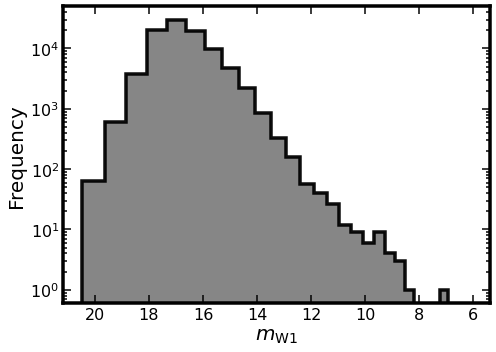

In [ ]:
fig             = plt.figure(figsize=(7,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

used_col        = 'W1MAG'

binss = np.logspace(np.nanmin(np.log10(large_catalog_full_df.loc[:, used_col])),\
                    np.nanmax(np.log10(large_catalog_full_df.loc[:, used_col])), 30)
ax1.hist(large_catalog_full_df.loc[:, used_col], bins=binss, fc='Gray', ec='k', histtype='stepfilled', alpha=0.95, lw=3.5);

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('$m_{\mathrm{W1}}$', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
ax1.invert_xaxis()
#ax1.set_xlim(left=0.2, right=2.4)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()

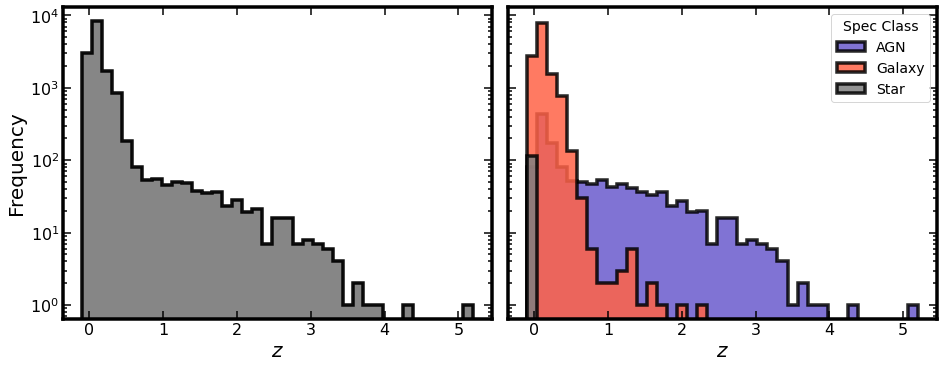

In [ ]:
# fig             = plt.figure(figsize=(7,5))
# ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

fig             = plt.figure(figsize=(13, 5), constrained_layout=True)

grid            = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[1, 1],\
                                   height_ratios=[1], hspace=0.1, wspace=0.01)
ax1             = fig.add_subplot(grid[0, 0], xscale='linear', yscale='log')
ax2             = fig.add_subplot(grid[0, 1], xscale='linear', yscale='log',\
                                  sharey=ax1, sharex=ax1)

used_col        = 'z_spec'

bins_z = np.linspace(np.nanmin(large_catalog_full_df.loc[:, used_col]),\
                    np.nanmax(large_catalog_full_df.loc[:, used_col]), 40)


ax1.hist(large_catalog_full_df.loc[:, used_col], bins=bins_z, fc='Gray', ec='k', histtype='stepfilled', alpha=0.95, lw=3.5);

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('$z$', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
#ax1.set_xlim(left=0.2, right=2.4)
#ax1.set_aspect('equal', 'box')


colors_l = ['Gray', 'slateblue', 'tomato']
ax2.hist(large_catalog_full_df.loc[large_catalog_full_df.loc[:, 'spec_class'] == 1, used_col],\
         bins=bins_z, fc=colors_l[1], ec='k', histtype='stepfilled', alpha=0.85, lw=3.5, label='AGN');
ax2.hist(large_catalog_full_df.loc[large_catalog_full_df.loc[:, 'spec_class'] == 2, used_col],\
         bins=bins_z, fc=colors_l[2], ec='k', histtype='stepfilled', alpha=0.85, lw=3.5, label='Galaxy');
ax2.hist(large_catalog_full_df.loc[large_catalog_full_df.loc[:, 'spec_class'] == 0, used_col],\
         bins=bins_z, fc=colors_l[0], ec='k', histtype='stepfilled', alpha=0.85, lw=3.5, label='Star');

ax2.tick_params(which='both', top=True, right=True, direction='in')
ax2.tick_params(axis='both', which='major', labelsize=16)
ax2.tick_params(which='major', length=8, width=1.5)
ax2.tick_params(which='minor', length=4, width=1.5)
ax2.set_xlabel('$z$', size=20)
# ax2.set_ylabel('Frequency', size=20)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax2.spines.values(), linewidth=3.5)
plt.setp(ax2.spines.values(), linewidth=3.5)
plt.legend(loc=1, title='Spec Class', fontsize=14, title_fontsize=14)

fig.tight_layout()

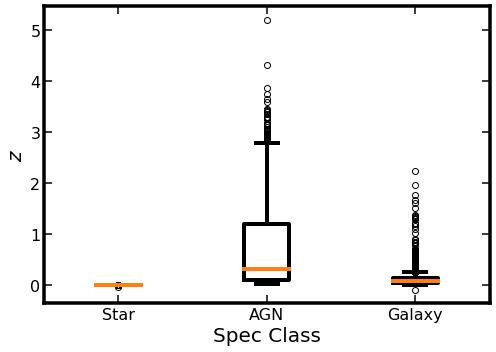

In [ ]:
fig             = plt.figure(figsize=(7,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')

used_col        = 'z_spec'

boxprops_a = dict(linewidth=4)

data_class = np.array([large_catalog_full_df.loc[large_catalog_full_df.loc[:, 'spec_class'] == 0, used_col],\
              large_catalog_full_df.loc[large_catalog_full_df.loc[:, 'spec_class'] == 1, used_col],\
              large_catalog_full_df.loc[large_catalog_full_df.loc[:, 'spec_class'] == 2, used_col]])
ax1.boxplot(data_class, labels=['Star', 'AGN', 'Galaxy'], showfliers=True,\
            boxprops=boxprops_a, whiskerprops=boxprops_a, capprops=boxprops_a,\
            medianprops=boxprops_a, autorange=True)

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Spec Class', size=20)
ax1.set_ylabel('$z$', size=20)

plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
#ax1.set_xlim(left=0.2, right=2.4)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()

Create `pandas`DataFrames for redhisft and coordinates.

In [ ]:
redshift_df           = large_catalog_full_df['z_spec']

Calculate colours for several pairs of magnitudes in the sample.

In [ ]:
large_catalog_full_df['u_g']            = large_catalog_full_df['MAG_U']    - large_catalog_full_df['MAG_G']
large_catalog_full_df['g_r']            = large_catalog_full_df['MAG_G']    - large_catalog_full_df['MAG_R']
large_catalog_full_df['r_i']            = large_catalog_full_df['MAG_R']    - large_catalog_full_df['MAG_I']
large_catalog_full_df['i_z']            = large_catalog_full_df['MAG_I']    - large_catalog_full_df['MAG_Z']
large_catalog_full_df['u_r']            = large_catalog_full_df['MAG_U']    - large_catalog_full_df['MAG_R']  # ~U-V
large_catalog_full_df['g_i']            = large_catalog_full_df['MAG_G']    - large_catalog_full_df['MAG_I']
large_catalog_full_df['w1_w2']          = large_catalog_full_df['W1MAG']    - large_catalog_full_df['W2MAG']
large_catalog_full_df['J_K']            = large_catalog_full_df['J_VISTA']  - large_catalog_full_df['KS_VISTA']
large_catalog_full_df['u_radio']        = large_catalog_full_df['MAG_U']    - large_catalog_full_df['flux_int']
large_catalog_full_df['w1_radio']       = large_catalog_full_df['W1MAG']    - large_catalog_full_df['flux_int']
large_catalog_full_df['K_radio']        = large_catalog_full_df['KS_VISTA'] - large_catalog_full_df['flux_int']

In [ ]:
np.shape(large_catalog_full_df)

(92013, 30)

---

In [ ]:
print(large_catalog_full_df.columns)

Index(['Unnamed: 0', 'catalogue_id', 'n_components', 'flux_int', 'flux_peak',
       'quality_level', 'SOURCEID_VISTA', 'W1MAG', 'W2MAG', 'J_VISTA',
       'KS_VISTA', 'PSTAR_VISTA', 'MAG_U', 'MAG_G', 'MAG_R', 'MAG_I', 'MAG_Z',
       'z_spec', 'spec_class', 'u_g', 'g_r', 'r_i', 'i_z', 'u_r', 'g_i',
       'w1_w2', 'J_K', 'u_radio', 'w1_radio', 'K_radio'],
      dtype='object')


In [ ]:
cols2discard_reg = ['Unnamed: 0', 'catalogue_id', 'n_components', 'flux_peak',\
                'quality_level', 'SOURCEID_VISTA', 'spec_class']

Let's set a random seed for future aplications.

In [ ]:
seed = 42

---

# Using Pycaret

We will start with the non-normalised data. We will let PyCaret (https://pycaret.org) do it for us.

In order to test more capabilities, we will divide our data into three sub-samples: train, test, and validation sets.  

PyCaret will use tran and test sets and we will let a $10\%$ of the data for final validation (not touched by the models).

PyCaret can take, automatically, a $70\%$ of the data for training and a $30\%$ for testing.

It will also perform most of its training routines using 10-fold CV.

In [ ]:
seed = 42

In [ ]:
data_train_test_df = large_catalog_full_df.loc[np.isfinite(large_catalog_full_df.loc[:, 'z_spec']), :]  # Train + test sets
data_validation_df = large_catalog_full_df.drop(data_train_test_df.index)  # Validation data

print('Shape of used data')
print('-' * 40)
print(f'Full Dataset size: {large_catalog_full_df.shape}')
print(f'Data for Modeling (Train and Test): {data_train_test_df.shape}')
print(f'Unseen Data For Validation: {data_validation_df.shape}')
print('-' * 40)

Shape of used data
----------------------------------------
Full Dataset size: (92013, 30)
Data for Modeling (Train and Test): (14699, 30)
Unseen Data For Validation: (77314, 30)
----------------------------------------


---

---

Now, we set PyCaret up. There are several options, and some of them might be different depending on whether we are running regression, classification, or other tasks (https://pycaret.readthedocs.io/en/latest/api/regression.html).

We will let PyCaret select the most relevant features by using the Boruta method (https://danielhomola.com/feature%20selection/phd/borutapy-an-all-relevant-feature-selection-method/).  

Also, we want to normalise our training features (not the target) with zscores (i.e., each feature will have a mean value, mu=0, and a standard deviation, sigma=1).

There are many more options (https://pycaret.readthedocs.io/en/latest/api/regression.html#pycaret.regression.setup).

**Important**: Note that now we have the parameter `use_gpu='force'`. That makes PyCaret use only the GPU versions of models that have both options (CPU and GPU).

## Redshift Prediction

In [ ]:
exp_mreg = pyr.setup(data=data_train_test_df, target='z_spec', session_id=seed, silent=True,\
                     feature_selection=True, feature_selection_method='boruta',\
                     ignore_features=cols2discard_reg, transformation=True,\
                     transformation_method='yeo-johnson', n_jobs=-1, normalize=True,\
                     normalize_method='zscore', use_gpu='force')  # 5 minutes

,Description,Value
0,session_id,42
1,Target,z_spec
2,Original Data,"(14699, 30)"
3,Missing Values,False
4,Numeric Features,22
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(10289, 12)"


In [ ]:
pyr.get_config('X').columns

Index(['W1MAG', 'W2MAG', 'J_VISTA', 'KS_VISTA', 'PSTAR_VISTA', 'MAG_G',
       'MAG_R', 'MAG_I', 'MAG_Z', 'w1_w2', 'J_K', 'w1_radio'],
      dtype='object')

We can see, from the output, that some features have been discarded. This might help our models to run faster.

At this point, we add our custom scoring function for redshifts.

In [ ]:
pyr.add_metric('z_met', 'delta z', delta_z, greater_is_better=False)

Name                                                       delta z
Display Name                                               delta z
Score Function                <function delta_z at 0x7f7180902170>
Scorer               make_scorer(delta_z, greater_is_better=False)
Target                                                        pred
Args                                                            {}
Greater is Better                                            False
Custom                                                        True
Name: z_met, dtype: object

Just to have more information, we see the models that are available for use in the system.

In [ ]:
pyr.models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,cuml.linear_model.linear_regression.LinearRegr...,True
lasso,Lasso Regression,cuml.linear_model.lasso.Lasso,True
ridge,Ridge Regression,cuml.linear_model.ridge.Ridge,True
en,Elastic Net,cuml.linear_model.elastic_net.ElasticNet,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


Since we want to take advantage of the GPU, we want to only use models that are installed through RAPIDS.ai. That means, we want those which start with `cuml...` and not those with `sklearn..`. Also we will prefer those which have `Turbo=True`, they are intrinsically faster.

If we want, we can also use `xgboost`, `lightgbm`, and `catboost`. They have the capabilities to use GPU.

Now, instead of looking at some text to understand what models are better for our regression problem and the structure of our data, we can ask PyCaret to, quickly, test many models and select the ones that behave the best for us.

We want to stack (https://en.wikipedia.org/wiki/Ensemble_learning#Stacking) the five best models, so we are selecting them directly from the comparison. Also, some models are excluded from this task since, from previous runs, they behave really bad.

In [ ]:
# Catboost uses GPU only if rows > 50000
gpu_ready_models = ['lr', 'ridge', 'svm', 'knn', 'rf', 'xgboost', 'lightgbm']  # CatBoost too slow

top5_reg = pyr.compare_models(n_select=5, include=gpu_ready_models, sort='z_met')  # 57 seconds

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,delta z,TT (Sec)
knn,K Neighbors Regressor,0.0464,0.0232,0.1512,0.7815,0.0730,22.4522,0.0146,0.182
xgboost,Extreme Gradient Boosting,0.0463,0.0224,0.1484,0.7861,0.0727,25.4266,0.0149,1.151
rf,Random Forest Regressor,0.0493,0.0264,0.1615,0.7519,0.0773,13.7571,0.0152,0.990
lightgbm,Light Gradient Boosting Machine,0.0453,0.0203,0.1407,0.8090,0.0684,19.1476,0.0163,1.152
svm,Support Vector Regression,0.0562,0.0215,0.1459,0.7979,0.0732,34.4984,0.0280,0.232
ridge,Ridge Regression,0.1036,0.0437,0.2085,0.5927,0.1153,130.2102,0.0556,0.015
lr,Linear Regression,0.1037,0.0437,0.2085,0.5926,0.1153,129.8258,0.0557,0.811


At this step, we let PyCaret stack the models we have just selected. The best model will be used as meta model, using the outputs of the other four models as new features.

In [ ]:
pyr_stacked = pyr.stack_models(estimator_list=top5_reg[1::], meta_model=top5_reg[0])  # 3 minutes

,MAE,MSE,RMSE,R2,RMSLE,MAPE,delta z
0,0.0434,0.0193,0.1390,0.8108,0.0696,19.3085,0.0146
1,0.0475,0.0306,0.1750,0.7038,0.0825,0.4608,0.0143
2,0.0508,0.0332,0.1821,0.6799,0.0889,16.4931,0.0148
3,0.0427,0.0181,0.1347,0.8497,0.0576,1.2568,0.0136
4,0.0417,0.0179,0.1337,0.7604,0.0686,40.7686,0.0152
5,0.0457,0.0225,0.1501,0.7752,0.0753,5.8723,0.0148
6,0.0416,0.0159,0.1262,0.8413,0.0674,13.1255,0.0141
7,0.0519,0.0314,0.1773,0.7399,0.0842,10.2573,0.0157
8,0.0450,0.0202,0.1421,0.8157,0.0648,0.5081,0.0142
9,0.0441,0.0162,0.1274,0.8907,0.0568,9.2197,0.0145


If we didn't want to stack models, we could have just used the best-performing model.

In [ ]:
# pyr_model  = top5[0]

Now, we can tune the hyperparameters of the selected (stacked) model. This step should take quite a long time.  

In the case of classification, I recommend using `optimize='MCC'`. That metric works better with heavily unbalanced data.

In [ ]:
tuned_stacked_reg = pyr.tune_model(pyr_stacked, early_stopping='asha', optimize='z_met')  # 38 minutes

,MAE,MSE,RMSE,R2,RMSLE,MAPE,delta z
0,0.0409,0.0183,0.1354,0.8206,0.0662,36.1352,0.0144
1,0.0459,0.0288,0.1697,0.7215,0.0815,0.4660,0.0138
2,0.0454,0.0260,0.1611,0.7495,0.0799,6.7895,0.0141
3,0.0404,0.0165,0.1284,0.8635,0.0533,9.8588,0.0136
4,0.0397,0.0151,0.1228,0.7978,0.0681,54.4978,0.0141
5,0.0442,0.0216,0.1469,0.7848,0.0727,6.8512,0.0139
6,0.0389,0.0137,0.1170,0.8636,0.0628,18.1964,0.0141
7,0.0479,0.0250,0.1580,0.7934,0.0763,20.5134,0.0159
8,0.0417,0.0172,0.1311,0.8431,0.0605,57.2834,0.0138
9,0.0432,0.0156,0.1250,0.8949,0.0548,17.4550,0.0134


After being tuned, we can see the model's properties. We can see PyCaret configurations, the meta-model parameters and the individual estimators' parameters as well.

In [ ]:
print(tuned_stacked_reg)

StackingRegressor(cv=KFold(n_splits=10, random_state=RandomState(MT19937) at 0x7F711DA398D0,
   shuffle=False),
                  estimators=[('xgboost',
                               XGBRegressor(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            gpu_id=0, importance_type='gain',
                                            interaction_constraints='',
                                            learning_rate=0.300000012,
                                            max_delta_step=0, max_depth=...
                                             learning_rate=0.1, max_depth=-1,
                                             min_child_samples=20,
                                             min_child_weight=0.001,
                                             min_split_

We can check how our model is doing, letting PyCaret prepare some plots (https://pycaret.org/plot-model/). Of course, we can also do it by ourselves.

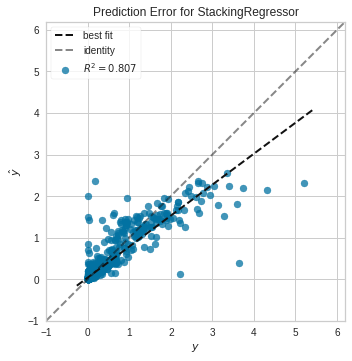

In [ ]:
pyr.plot_model(tuned_stacked_reg, plot='error')

In [ ]:
# pyr.plot_model(tuned_stacked_reg.estimators_[1], plot='tree')  # Only available for scikit-learn Decision Trees and Forests

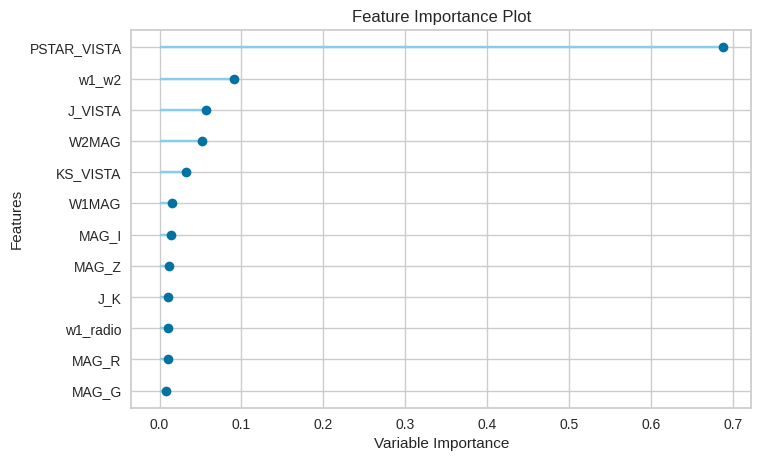

In [ ]:
pyr.plot_model(tuned_stacked_reg.estimators_[0], plot='feature_all')

C extension was not built during install!


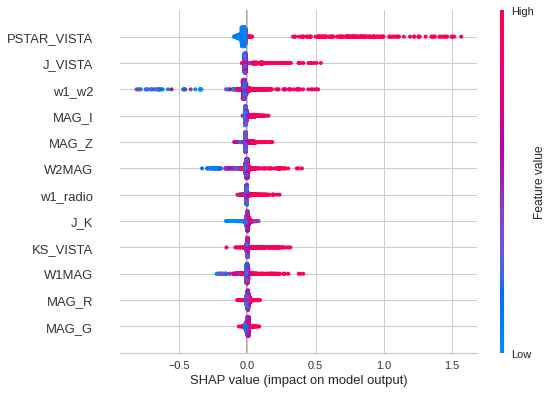

In [ ]:
pyr.interpret_model(tuned_stacked_reg.estimators_[2])

In [ ]:
# pyr.plot_model(tuned_stacked_reg, plot='residuals')

Reset `matplotlib` configuration. PyCaret modifies them.

In [ ]:
plt.rcParams.update(plt.rcParamsDefault)

If we are satisfied with the results, we can finalise the model. That means, to include the test data into the training set and re-run the models and optimise their parameters.

In [ ]:
final_stacked_reg = pyr.finalize_model(tuned_stacked_reg)  # 4 minutes

Let's check its parameters:

In [ ]:
print(final_stacked_reg)

StackingRegressor(cv=KFold(n_splits=10, random_state=RandomState(MT19937) at 0x7F70D80675A0,
   shuffle=False),
                  estimators=[('xgboost',
                               XGBRegressor(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            gpu_id=0, importance_type='gain',
                                            interaction_constraints='',
                                            learning_rate=0.300000012,
                                            max_delta_step=0, max_depth=...
                                             learning_rate=0.1, max_depth=-1,
                                             min_child_samples=20,
                                             min_child_weight=0.001,
                                             min_split_

---

The model and PyCaret configuration files can be saved and/or downloaded for future use (to avoid extra running time.)  


**Important** Now that models take a lot of time to run and train, it is recommended to save the files (following lines), download them, and put them in some place you can obtain them easily (e.g., Google Drive). That way, you might save some time if you need to stop working for some time, avoiding running everything again.

In [ ]:
pyr.save_model(final_stacked_reg, 'model_final_RACS_SM_z')  # Model (it will be saved with .pkl extension)
# pyr.save_config('config_final_RACS_SM_z')  # Configuration file

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False,
                                       features_todrop=['Unnamed: 0',
                                                        'catalogue_id',
                                                        'n_components',
                                                        'flux_peak',
                                                        'quality_level',
                                                        'SOURCEID_VISTA',
                                                        'spec_class'],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[], target='z_spec',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categori...
                                 

Now, if we want to load the saved files, we can do it.

In [ ]:
# if not os.path.exists('config_final_SDSS_z'):
#     # Run your code to get the file

In [ ]:
# if not os.path.exists('model_final_SDSS_z.pkl'):
#     # Run your code to get the file

In [ ]:
# pyr.load_config('config_final_RACS_SM_z')

In [ ]:
final_stacked_reg = pyr.load_model('model_final_RACS_SM_z')

Transformation Pipeline and Model Successfully Loaded


---

Now that our model is complete, we can apply it to the validation set.

First, we can just apply it, without saving the results. That way, we can obtain some statistics on the model.

In [ ]:
pyr.predict_model(final_stacked_reg, data=data_validation_df)

,Unnamed: 0,catalogue_id,n_components,flux_int,flux_peak,quality_level,SOURCEID_VISTA,W1MAG,W2MAG,J_VISTA,KS_VISTA,PSTAR_VISTA,MAG_U,MAG_G,MAG_R,MAG_I,MAG_Z,z_spec,spec_class,u_g,g_r,r_i,i_z,u_r,g_i,w1_w2,J_K,u_radio,w1_radio,K_radio,Label
0,0,54,1,19.226921,16.343929,UNCERTAIN,44816779,18.024000,17.441000,18.542423,18.482422,9.999990e-01,18.543501,18.745899,18.737600,18.458900,18.771000,NaN,NaN,-0.202398,0.008299,0.278700,-0.312099,-0.194099,0.286999,0.583000,0.060001,-0.683420,-1.202921,-0.744499,1.559698
4,6,56,1,21.787254,18.053860,UNCERTAIN,40086866,17.344000,16.853001,17.825172,17.349026,5.292210e-07,18.728201,18.710100,18.599001,18.697001,18.840000,NaN,NaN,0.018101,0.111099,-0.098000,-0.143000,0.129200,0.013100,0.490999,0.476147,-3.059053,-4.443254,-4.438229,0.368535
5,7,2552,1,14.552652,14.587673,NOT_VALIDATED,1301458660,17.827999,17.170000,18.353678,18.374390,9.999265e-01,17.815201,18.167000,18.077000,17.823000,17.725000,NaN,NaN,-0.351799,0.090000,0.254000,0.098000,-0.261799,0.344000,0.657999,-0.020712,3.262548,3.275347,3.821737,1.532024
8,11,91,1,21.514393,17.613630,UNCERTAIN,561748636,17.209999,17.085001,17.127022,16.866854,3.067485e-03,18.193001,17.854799,18.804001,18.028000,17.409000,NaN,NaN,0.338202,-0.949202,0.776001,0.618999,-0.611000,-0.173201,0.124998,0.260168,-3.321392,-4.304394,-4.647539,0.180837
9,12,3076,1,16.927813,16.253935,NOT_VALIDATED,34038911,17.230000,16.884001,17.071678,16.765747,1.714090e-04,19.112400,19.035900,18.920300,18.389799,18.705999,NaN,NaN,0.076500,0.115601,0.530500,-0.316200,0.192101,0.646101,0.345999,0.305931,2.184587,0.302187,-0.162066,0.262804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92008,259247,1484,1,15.057343,14.844983,NOT_VALIDATED,408577571,14.490001,13.830000,17.293709,15.488930,4.864865e-01,18.396000,17.962200,18.754999,17.862000,18.091000,NaN,NaN,0.433800,-0.792799,0.893000,-0.229000,-0.358999,0.100201,0.660001,1.804779,3.338657,-0.567342,0.431587,0.414541
92009,259248,2345,1,16.244486,15.515209,NOT_VALIDATED,1264762793,17.861000,17.378000,18.179733,17.616943,9.996572e-01,18.629299,18.298000,18.506001,18.490000,18.274000,NaN,NaN,0.331299,-0.208000,0.016001,0.216000,0.123299,-0.191999,0.483000,0.562790,2.384813,1.616514,1.372458,1.820621
92010,259249,2758,1,16.405443,15.796757,NOT_VALIDATED,156268380,17.320999,16.871000,17.172319,17.063625,3.067485e-03,18.400299,18.384001,17.978001,17.625999,17.493999,NaN,NaN,0.016298,0.406000,0.352001,0.132000,0.422298,0.758001,0.449999,0.108694,1.994856,0.915556,0.658182,0.172140
92011,259250,3022,1,10.339087,10.395164,NOT_VALIDATED,963484513,14.105000,13.830000,14.990262,14.460981,9.996572e-01,17.547001,16.882999,16.667000,16.214001,15.993000,NaN,NaN,0.664001,0.216000,0.452999,0.221001,0.880001,0.668999,0.275001,0.529281,7.207914,3.765914,4.121895,0.462058


This time, let's save the values. The column **Label** has the predictions.

In [ ]:
seen_predictions_reg   = pyr.predict_model(final_stacked_reg, data=data_train_test_df)

In [ ]:
unseen_predictions_reg = pyr.predict_model(final_stacked_reg, data=data_validation_df)

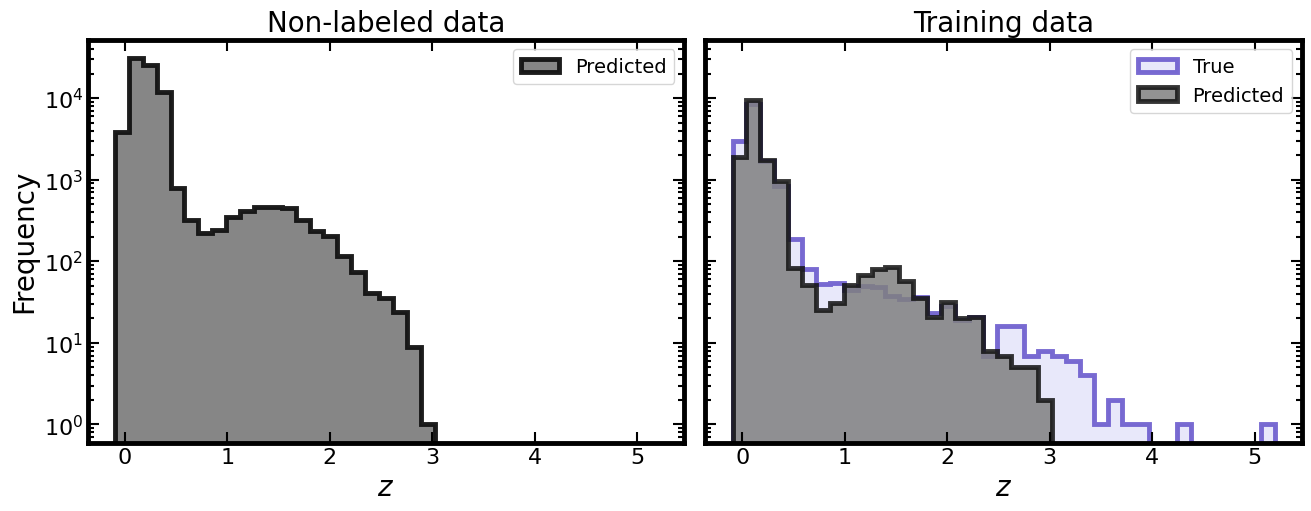

In [ ]:
# fig             = plt.figure(figsize=(7,5))
# ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

fig             = plt.figure(figsize=(13, 5), constrained_layout=True)

grid            = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[1, 1],\
                                   height_ratios=[1], hspace=0.1, wspace=0.01)
ax1             = fig.add_subplot(grid[0, 0], xscale='linear', yscale='log')
ax2             = fig.add_subplot(grid[0, 1], xscale='linear', yscale='log',\
                                  sharey=ax1, sharex=ax1)

used_col        = 'Label'
used_col_b      = 'z_spec'

# bins_z_a = np.linspace(np.nanmin(unseen_predictions_reg.loc[:, [used_col, used_col_b]].min()),\
#                     np.nanmax(unseen_predictions_reg.loc[:, [used_col, used_col_b]].max()), 40)

bins_z_b = np.linspace(np.nanmin(seen_predictions_reg.loc[:, [used_col, used_col_b]].min()),\
                    np.nanmax(seen_predictions_reg.loc[:, [used_col, used_col_b]].max()), 40)
ax1.hist(unseen_predictions_reg.loc[:, used_col], bins=bins_z_b, fc='Gray', ec='k',\
         histtype='stepfilled', alpha=0.95, lw=3.5, label='Predicted');

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('$z$', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
ax1.set_title('Non-labeled data', fontsize=20)
ax1.legend(loc=1, fontsize=14)
#ax1.set_xlim(left=0.2, right=2.4)
ax1.set_ylim(bottom=6e-1)
#ax1.set_aspect('equal', 'box')


ax2.hist(seen_predictions_reg.loc[:, 'z_spec'], bins=bins_z_b, fc='lavender', ec='slateblue',\
         histtype='stepfilled', alpha=0.90, lw=3.5, label='True');
ax2.hist(seen_predictions_reg.loc[:, used_col], bins=bins_z_b, fc='Gray', ec='k',\
         histtype='stepfilled', alpha=0.85, lw=3.5, label='Predicted');


ax2.tick_params(which='both', top=True, right=True, direction='in')
ax2.tick_params(axis='both', which='major', labelsize=16)
ax2.tick_params(which='major', length=8, width=1.5)
ax2.tick_params(which='minor', length=4, width=1.5)
ax2.set_xlabel('$z$', size=20)
plt.setp(ax2.get_yticklabels(), visible=False)
# ax2.set_ylabel('Frequency', size=20)
plt.setp(ax2.spines.values(), linewidth=3.5)
plt.setp(ax2.spines.values(), linewidth=3.5)
ax2.set_title('Training data', fontsize=20)
ax2.legend(loc=1, fontsize=14)
#ax1.set_xlim(left=0.2, right=2.4)
#ax1.set_aspect('equal', 'box')


fig.tight_layout()

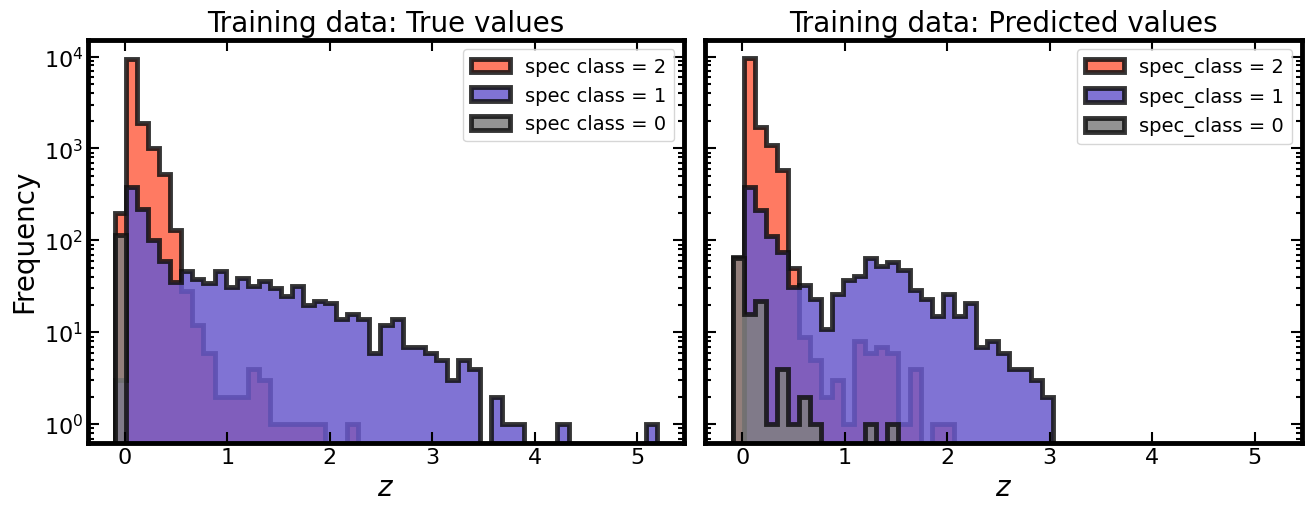

In [ ]:
# fig             = plt.figure(figsize=(7,5))
# ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

fig             = plt.figure(figsize=(13, 5), constrained_layout=True)

grid            = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[1, 1],\
                                   height_ratios=[1], hspace=0.1, wspace=0.01)
ax1             = fig.add_subplot(grid[0, 0], xscale='linear', yscale='log')
ax2             = fig.add_subplot(grid[0, 1], xscale='linear', yscale='log',\
                                  sharey=ax1, sharex=ax1)

used_col_1      = 'z_spec'
used_col_2      = 'Label'

bins_z = np.linspace(np.nanmin(seen_predictions_reg.loc[:, used_col_1]),\
                    np.nanmax(seen_predictions_reg.loc[:, used_col_1]), 50)

colors_l = ['Gray', 'slateblue', 'tomato']

for idx in range(3)[::-1]:
    ax1.hist(seen_predictions_reg.loc[(seen_predictions_reg.loc[:, 'spec_class'] == idx), used_col_1],\
             bins=bins_z, fc=colors_l[idx], ec='k', histtype='stepfilled',\
             alpha=0.85, lw=3.5, label=f'spec class = {idx}')

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('$z$', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
ax1.legend(loc=1, fontsize=14)
ax1.set_title('Training data: True values', fontsize=20)
#ax1.set_xlim(left=0.2, right=2.4)
#ax1.set_aspect('equal', 'box')


for idx in range(3)[::-1]:
    ax2.hist(seen_predictions_reg.loc[(seen_predictions_reg.loc[:, 'spec_class'] == idx), used_col_2],\
             bins=bins_z, fc=colors_l[idx], ec='k', histtype='stepfilled',\
             alpha=0.85, lw=3.5, label=f'spec_class = {idx}')

ax2.tick_params(which='both', top=True, right=True, direction='in')
ax2.tick_params(axis='both', which='major', labelsize=16)
ax2.tick_params(which='major', length=8, width=1.5)
ax2.tick_params(which='minor', length=4, width=1.5)
ax2.set_xlabel('$z$', size=20)
# ax2.set_ylabel('Frequency', size=20)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax2.spines.values(), linewidth=3.5)
plt.setp(ax2.spines.values(), linewidth=3.5)
ax2.legend(loc=1, fontsize=14)
ax2.set_title('Training data: Predicted values', fontsize=20)


fig.tight_layout()

We can get some basic statistics.

In [ ]:
seen_predictions_reg[['z_spec', 'Label']].describe()

,z_spec,Label
count,14699.000000,14699.000000
mean,0.169074,0.168403
std,0.327810,0.296122
min,-0.094330,-0.000023
25%,0.047490,0.053559
50%,0.074970,0.075658
75%,0.156650,0.161257
max,5.194587,2.951040


And, of course, we can also get a plot comparing our results.

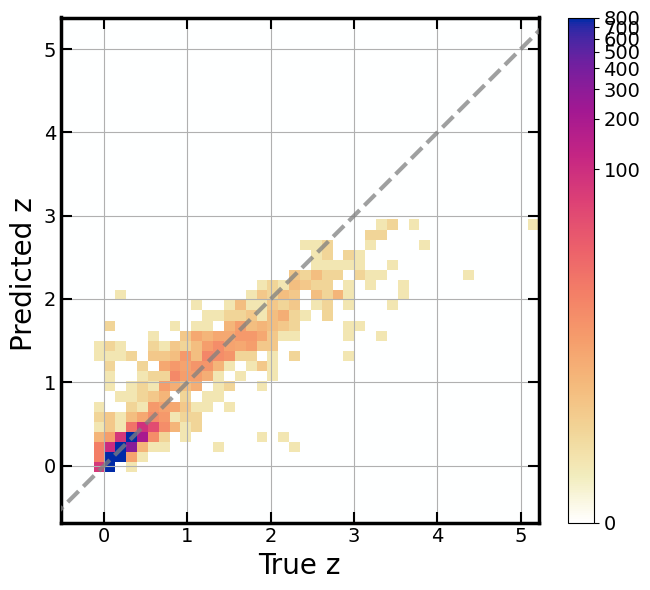

In [ ]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111, projection='scatter_density')

vert_range      = np.arange(-1, 6, 0.5)


norm = ImageNormalize(vmin=0., vmax=8e2, stretch=LogStretch())

min_lim = np.nanmin([np.nanmin(seen_predictions_reg.loc[:, 'z_spec']),\
                     np.nanmin(seen_predictions_reg.loc[:, 'Label'])])
max_lim = np.nanmax([np.nanmax(seen_predictions_reg.loc[:, 'z_spec']),\
                     np.nanmax(seen_predictions_reg.loc[:, 'Label'])])

dens_1 = ax1.scatter_density(seen_predictions_reg.loc[:, 'z_spec'],\
            seen_predictions_reg.loc[:, 'Label'],\
            cmap=plt.get_cmap('cet_CET_L17'), zorder=0, dpi=10, norm=norm, alpha=1)
ax1.plot(vert_range, vert_range, ls='--', marker=None, c='Gray', alpha=0.75, lw=3.0, zorder=10)

clb = plt.colorbar(dens_1)
clb.ax.tick_params(labelsize=14)
clb.outline.set_linewidth(2.5)
clb.ax.set_ylabel('Points per pixel', size=20, path_effects=pe2)

ax1.set_xlabel('True z', fontsize=20)
ax1.set_ylabel('Predicted z ', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
ax1.set_xlim(left=-0.5, right=max_lim)
ax1.set_ylim(bottom=-0.5, top=max_lim)
ax1.grid(zorder=0)
ax1.set_aspect('equal', 'datalim')
fig.tight_layout()

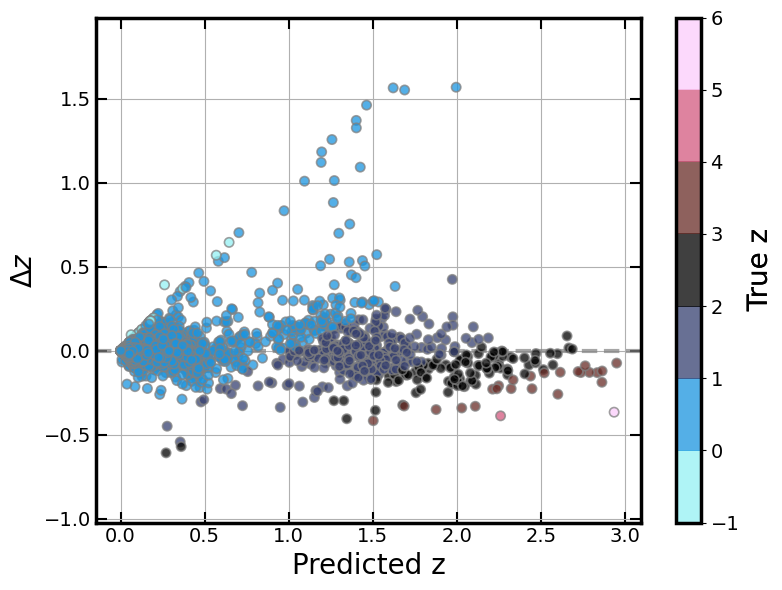

In [ ]:
fig             = plt.figure(figsize=(8,6))
ax1             = fig.add_subplot(111)

norm_z = mcolors.Normalize(vmin=np.floor(np.nanmin(seen_predictions_reg.loc[:, 'z_spec'])),\
                           vmax=np.ceil(np.nanmax(seen_predictions_reg.loc[:, 'z_spec'])))
bins_num = int(np.ceil(np.nanmax(seen_predictions_reg.loc[:, 'z_spec'])) -\
             np.floor(np.nanmin(seen_predictions_reg.loc[:, 'z_spec'])))

res_z_z     = seen_predictions_reg.loc[:, 'Label'] - seen_predictions_reg.loc[:, 'z_spec']
delt_z      = res_z_z / (1 + seen_predictions_reg.loc[:, 'z_spec'])

sc_p = ax1.scatter(seen_predictions_reg.loc[:, 'Label'].sample(frac=1, random_state=seed),\
                   delt_z.sample(frac=1, random_state=seed),\
                   c=seen_predictions_reg.loc[:, 'z_spec'].sample(frac=1, random_state=seed),\
                   s=45, ec='Gray', alpha=0.75, lw=1.2,\
                   cmap=plt.get_cmap('cmr.redshift', bins_num), zorder=10, norm=norm_z)
ax1.axhline(y=0, ls='--', marker=None, c='Gray', alpha=0.7, lw=3.0)

clb             = plt.colorbar(sc_p)
clb.ax.tick_params(labelsize=14)
clb.outline.set_linewidth(2.5)
clb.ax.set_ylabel('True z', size=20, path_effects=pe2)

ax1.set_xlabel('Predicted z', fontsize=20)
ax1.set_ylabel('$\Delta z$', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
ax1.grid(zorder=0)
ax1.set_aspect('equal', 'datalim')
fig.tight_layout()

Extract prediction for full dataset for using it in next steps.

In [ ]:
full_prediction_reg_df = pyr.predict_model(final_stacked_reg, data=large_catalog_full_df)

In [ ]:
full_prediction_reg_df = full_prediction_reg_df.rename(columns={'Label': 'z_pred'})

---

## Spec Class prediction

In [ ]:
# cols2discard_clf = ['Unnamed: 0', 'catalogue_id', 'n_components', 'flux_peak',\
#                 'quality_level', 'SOURCEID_VISTA', 'z_spec', 'z_pred']
cols2discard_clf = ['Unnamed: 0', 'catalogue_id', 'n_components', 'flux_peak',\
                'quality_level', 'SOURCEID_VISTA', 'z_pred']  # using 'z_spec'

In [ ]:
data_train_test_clf_df = full_prediction_reg_df.loc[np.isfinite(full_prediction_reg_df.loc[:, 'spec_class']), :]  # Train + test sets
# data_train_test_clf_df = full_prediction_reg_df.sample(frac=0.9, random_state=seed)  # Train + test sets
data_validation_clf_df = full_prediction_reg_df.drop(data_train_test_clf_df.index)  # Validation data

print('Shape of used data')
print('-' * 40)
print(f'Full Dataset size: {full_prediction_reg_df.shape}')
print(f'Data for Modeling (Train and Test): {data_train_test_clf_df.shape}')
print(f'Unseen Data For Validation: {data_validation_clf_df.shape}')
print('-' * 40)

Shape of used data
----------------------------------------
Full Dataset size: (92013, 31)
Data for Modeling (Train and Test): (14699, 31)
Unseen Data For Validation: (77314, 31)
----------------------------------------


In [ ]:
data_train_test_clf_df.loc[:, 'spec_class'] = data_train_test_clf_df.loc[:, 'spec_class'].astype(np.int32)

In [ ]:
data_train_test_clf_df.index = data_train_test_clf_df.index.astype('int32')

In [ ]:
data_train_test_clf_df.columns

Index(['Unnamed: 0', 'catalogue_id', 'n_components', 'flux_int', 'flux_peak',
       'quality_level', 'SOURCEID_VISTA', 'W1MAG', 'W2MAG', 'J_VISTA',
       'KS_VISTA', 'PSTAR_VISTA', 'MAG_U', 'MAG_G', 'MAG_R', 'MAG_I', 'MAG_Z',
       'z_spec', 'spec_class', 'u_g', 'g_r', 'r_i', 'i_z', 'u_r', 'g_i',
       'w1_w2', 'J_K', 'u_radio', 'w1_radio', 'K_radio', 'z_pred'],
      dtype='object')

In [ ]:
exp_mclf = pyc.setup(data=data_train_test_clf_df, target='spec_class', session_id=seed, silent=True,\
                     feature_selection=True, feature_selection_method='boruta',\
                     ignore_features=cols2discard_clf, transformation=True,\
                     transformation_method='yeo-johnson', n_jobs=-1, normalize=True,\
                     normalize_method='zscore', use_gpu='force')  # 25 seconds

,Description,Value
0,session_id,42
1,Target,spec_class
2,Target Type,Multiclass
3,Label Encoded,None
4,Original Data,"(14699, 31)"
5,Missing Values,False
6,Numeric Features,23
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
pyc.get_config('X').columns

Index(['flux_int', 'W1MAG', 'W2MAG', 'J_VISTA', 'KS_VISTA', 'PSTAR_VISTA',
       'MAG_U', 'MAG_G', 'MAG_R', 'MAG_I', 'MAG_Z', 'z_spec', 'u_g', 'g_r',
       'r_i', 'i_z', 'u_r', 'g_i', 'w1_w2', 'J_K', 'u_radio', 'w1_radio',
       'K_radio'],
      dtype='object')

In [ ]:
pyc.models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,cuml.linear_model.logistic_regression.Logistic...,True
knn,K Neighbors Classifier,cuml.neighbors.kneighbors_classifier.KNeighbor...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,cuml.linear_model.mbsgd_classifier.MBSGDClassi...,True
rbfsvm,SVM - Radial Kernel,pycaret.internal.cuml_wrappers.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,cuml.linear_model.ridge.Ridge,True


In [ ]:
# Catboost uses GPU only if rows > 50000
gpu_ready_models_clf = ['lr', 'knn', 'svm', 'ridge', 'rf', 'xgboost', 'lightgbm']  # Catboost too slow

top5_clf = pyc.compare_models(n_select=5, include=gpu_ready_models_clf, sort='MCC')  # 1 minute

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9476,0.9217,0.8529,0.9438,0.9433,0.6760,0.6872,1.600
lightgbm,Light Gradient Boosting Machine,0.9470,0.9191,0.8443,0.9435,0.9422,0.6681,0.6821,2.389
rf,Random Forest Classifier,0.9445,0.8971,0.8167,0.9406,0.9386,0.6439,0.6623,0.692
lr,Logistic Regression,0.9413,0.8972,0.7914,0.9367,0.9353,0.6237,0.6411,0.727
knn,K Neighbors Classifier,0.9387,0.8380,0.7753,0.9334,0.9326,0.6074,0.6240,0.354
ridge,Ridge Classifier,0.9328,0.0000,0.5081,0.9247,0.9224,0.5409,0.5712,0.083
svm,SVM - Linear Kernel,0.0295,0.0000,0.3724,0.0031,0.0056,-0.0446,-0.1542,4.921


In [ ]:
pyc_stacked = pyc.stack_models(estimator_list=top5_clf[1::], meta_model=top5_clf[0])  # 5 minutes. If meta is RF, will fail

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9456,0.9296,0.8445,0.9416,0.9406,0.6595,0.6726
1,0.9436,0.9267,0.8314,0.9392,0.9373,0.6365,0.6556
2,0.9320,0.9139,0.8394,0.9270,0.9288,0.6014,0.6046
3,0.9475,0.9223,0.8513,0.9436,0.9431,0.6746,0.6861
4,0.9446,0.9232,0.8195,0.9425,0.9364,0.6258,0.6584
5,0.9475,0.9025,0.8039,0.9442,0.9423,0.6647,0.6821
6,0.9436,0.9201,0.8314,0.9392,0.9373,0.6365,0.6556
7,0.9427,0.9147,0.8526,0.9383,0.9391,0.6563,0.6625
8,0.9485,0.9249,0.8456,0.9451,0.9433,0.6727,0.6893
9,0.9562,0.9444,0.8792,0.9537,0.9536,0.7349,0.7419


In [ ]:
tuned_stacked_clf = pyr.tune_model(pyc_stacked, early_stopping='asha', optimize='MCC')  # 50 minutes
# tuned_stacked_clf = pyr.tune_model(top5_clf[0], early_stopping='asha', optimize='MCC')  # 16 seconds, only RF, 2 minutes w/xgboost or lightgbm

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9456,0.9222,0.8475,0.9415,0.9410,0.6628,0.6741
1,0.9397,0.9300,0.8331,0.9341,0.9343,0.6228,0.6351
2,0.9368,0.9024,0.8351,0.9310,0.9322,0.6140,0.6221
3,0.9427,0.9198,0.8342,0.9377,0.9369,0.6357,0.6513
4,0.9475,0.8711,0.8267,0.9463,0.9400,0.6473,0.6792
5,0.9504,0.8708,0.8050,0.9485,0.9450,0.6785,0.7002
6,0.9417,0.9119,0.8307,0.9370,0.9355,0.6279,0.6445
7,0.9417,0.9050,0.8430,0.9368,0.9371,0.6421,0.6515
8,0.9514,0.9185,0.8497,0.9490,0.9463,0.6897,0.7079
9,0.9562,0.9284,0.8792,0.9537,0.9536,0.7349,0.7419


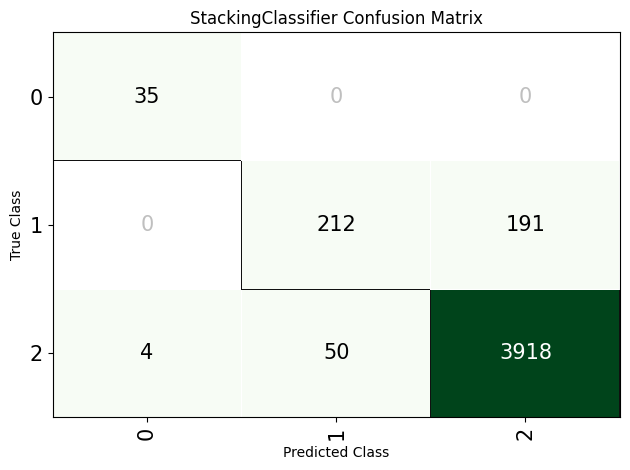

In [ ]:
pyc.plot_model(tuned_stacked_clf, plot='confusion_matrix')

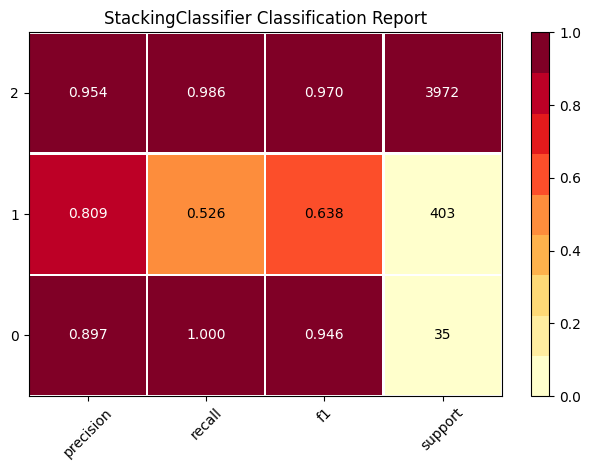

In [ ]:
pyc.plot_model(tuned_stacked_clf, plot='class_report')

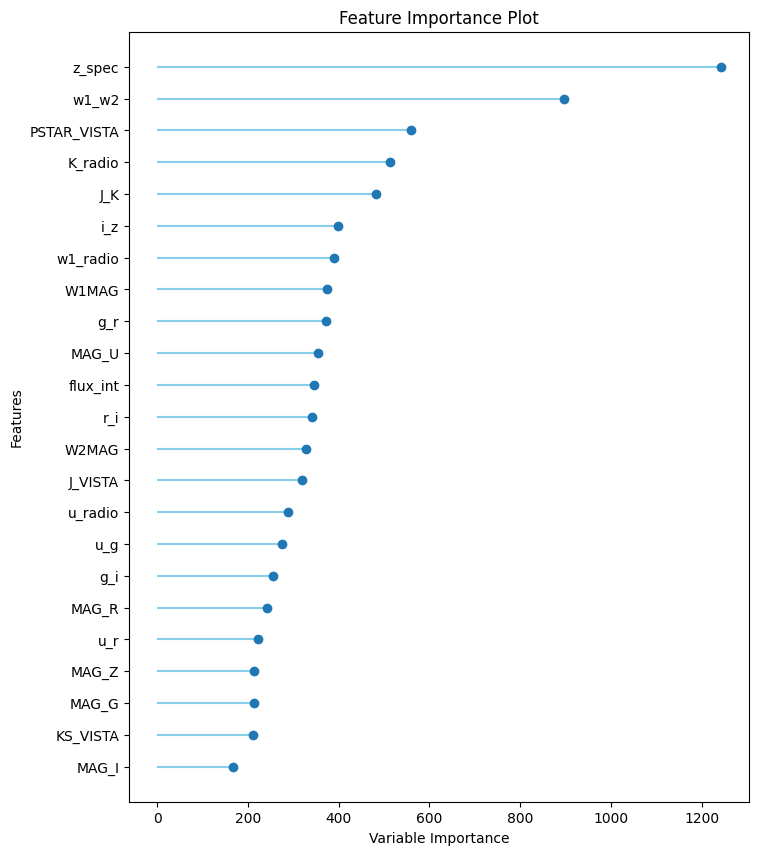

In [ ]:
pyc.plot_model(tuned_stacked_clf.estimators_[0], plot='feature_all')

In [ ]:
plt.rcParams.update(plt.rcParamsDefault)

In [ ]:
final_stacked_clf = pyc.finalize_model(tuned_stacked_clf)

[E] [19:02:28.092194] L-BFGS line search failed
[E] [19:02:51.069215] L-BFGS line search failed
[E] [19:02:51.163780] L-BFGS line search failed
[E] [19:03:20.478862] L-BFGS line search failed
[E] [19:03:26.373045] L-BFGS line search failed
[E] [19:03:49.452127] L-BFGS line search failed
[E] [19:03:49.749230] L-BFGS line search failed
[E] [19:03:55.739654] L-BFGS line search failed
[E] [19:04:54.398384] L-BFGS line search failed
[E] [19:05:17.176190] L-BFGS line search failed
[E] [19:05:46.132752] L-BFGS line search failed
[E] [19:05:52.750768] L-BFGS line search failed
[E] [19:06:15.427641] L-BFGS line search failed
[E] [19:06:15.530339] L-BFGS line search failed
[E] [19:06:44.679242] L-BFGS line search failed
[E] [19:06:44.895407] L-BFGS line search failed
[E] [19:06:45.313133] L-BFGS line search failed
[E] [19:06:51.345574] L-BFGS line search failed
[E] [19:07:14.117556] L-BFGS line search failed


In [ ]:
pyc.save_model(final_stacked_clf, 'model_final_RACS_SM_class')  # Model (it will be saved with .pkl extension)
# pyc.save_config('config_final_RACS_SM_class')  # Configuration file

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False,
                                       features_todrop=['Unnamed: 0',
                                                        'catalogue_id',
                                                        'n_components',
                                                        'flux_peak',
                                                        'quality_level',
                                                        'SOURCEID_VISTA',
                                                        'z_pred'],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='spec_class', time_features=[])),
                 ('imputer',
                  Simple_Imputer(ca

In [ ]:
# pyc.load_config('config_final_RACS_SM_class')

In [ ]:
final_stacked_clf = pyc.load_model('model_final_RACS_SM_class')

Transformation Pipeline and Model Successfully Loaded


In [ ]:
pyc.predict_model(final_stacked_clf, data=data_validation_clf_df)

,Unnamed: 0,catalogue_id,n_components,flux_int,flux_peak,quality_level,SOURCEID_VISTA,W1MAG,W2MAG,J_VISTA,KS_VISTA,PSTAR_VISTA,MAG_U,MAG_G,MAG_R,MAG_I,MAG_Z,z_spec,spec_class,u_g,g_r,r_i,i_z,u_r,g_i,w1_w2,J_K,u_radio,w1_radio,K_radio,z_pred,Label,Score
0,0,54,1,19.226921,16.343929,UNCERTAIN,44816779,18.024000,17.441000,18.542423,18.482422,9.999990e-01,18.543501,18.745899,18.737600,18.458900,18.771000,NaN,NaN,-0.202398,0.008299,0.278700,-0.312099,-0.194099,0.286999,0.583000,0.060001,-0.683420,-1.202921,-0.744499,1.559698,2,0.3333
4,6,56,1,21.787254,18.053860,UNCERTAIN,40086866,17.344000,16.853001,17.825172,17.349026,5.292210e-07,18.728201,18.710100,18.599001,18.697001,18.840000,NaN,NaN,0.018101,0.111099,-0.098000,-0.143000,0.129200,0.013100,0.490999,0.476147,-3.059053,-4.443254,-4.438229,0.368535,2,0.3334
5,7,2552,1,14.552652,14.587673,NOT_VALIDATED,1301458660,17.827999,17.170000,18.353678,18.374390,9.999265e-01,17.815201,18.167000,18.077000,17.823000,17.725000,NaN,NaN,-0.351799,0.090000,0.254000,0.098000,-0.261799,0.344000,0.657999,-0.020712,3.262548,3.275347,3.821737,1.532024,2,0.3333
8,11,91,1,21.514393,17.613630,UNCERTAIN,561748636,17.209999,17.085001,17.127022,16.866854,3.067485e-03,18.193001,17.854799,18.804001,18.028000,17.409000,NaN,NaN,0.338202,-0.949202,0.776001,0.618999,-0.611000,-0.173201,0.124998,0.260168,-3.321392,-4.304394,-4.647539,0.180837,2,0.3334
9,12,3076,1,16.927813,16.253935,NOT_VALIDATED,34038911,17.230000,16.884001,17.071678,16.765747,1.714090e-04,19.112400,19.035900,18.920300,18.389799,18.705999,NaN,NaN,0.076500,0.115601,0.530500,-0.316200,0.192101,0.646101,0.345999,0.305931,2.184587,0.302187,-0.162066,0.262804,2,0.3334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92008,259247,1484,1,15.057343,14.844983,NOT_VALIDATED,408577571,14.490001,13.830000,17.293709,15.488930,4.864865e-01,18.396000,17.962200,18.754999,17.862000,18.091000,NaN,NaN,0.433800,-0.792799,0.893000,-0.229000,-0.358999,0.100201,0.660001,1.804779,3.338657,-0.567342,0.431587,0.414541,2,0.3333
92009,259248,2345,1,16.244486,15.515209,NOT_VALIDATED,1264762793,17.861000,17.378000,18.179733,17.616943,9.996572e-01,18.629299,18.298000,18.506001,18.490000,18.274000,NaN,NaN,0.331299,-0.208000,0.016001,0.216000,0.123299,-0.191999,0.483000,0.562790,2.384813,1.616514,1.372458,1.820621,2,0.3333
92010,259249,2758,1,16.405443,15.796757,NOT_VALIDATED,156268380,17.320999,16.871000,17.172319,17.063625,3.067485e-03,18.400299,18.384001,17.978001,17.625999,17.493999,NaN,NaN,0.016298,0.406000,0.352001,0.132000,0.422298,0.758001,0.449999,0.108694,1.994856,0.915556,0.658182,0.172140,2,0.3334
92011,259250,3022,1,10.339087,10.395164,NOT_VALIDATED,963484513,14.105000,13.830000,14.990262,14.460981,9.996572e-01,17.547001,16.882999,16.667000,16.214001,15.993000,NaN,NaN,0.664001,0.216000,0.452999,0.221001,0.880001,0.668999,0.275001,0.529281,7.207914,3.765914,4.121895,0.462058,1,0.3333


In [ ]:
seen_predictions_clf   = pyc.predict_model(final_stacked_clf, data=data_train_test_clf_df)

In [ ]:
unseen_predictions_clf = pyc.predict_model(final_stacked_clf, data=data_validation_clf_df)

Create confusion matrices.

In [ ]:
cm_mat_seen = np.array([[np.sum(np.array(seen_predictions_clf['spec_class'] == 0) & np.array(seen_predictions_clf['Label'] == 0)),\
                         np.sum(np.array(seen_predictions_clf['spec_class'] == 0) & np.array(seen_predictions_clf['Label'] == 1)),\
                         np.sum(np.array(seen_predictions_clf['spec_class'] == 0) & np.array(seen_predictions_clf['Label'] == 2))],\
                        [np.sum(np.array(seen_predictions_clf['spec_class'] == 1) & np.array(seen_predictions_clf['Label'] == 0)),\
                         np.sum(np.array(seen_predictions_clf['spec_class'] == 1) & np.array(seen_predictions_clf['Label'] == 1)),\
                         np.sum(np.array(seen_predictions_clf['spec_class'] == 1) & np.array(seen_predictions_clf['Label'] == 2))],\
                        [np.sum(np.array(seen_predictions_clf['spec_class'] == 2) & np.array(seen_predictions_clf['Label'] == 0)),\
                         np.sum(np.array(seen_predictions_clf['spec_class'] == 2) & np.array(seen_predictions_clf['Label'] == 1)),\
                         np.sum(np.array(seen_predictions_clf['spec_class'] == 2) & np.array(seen_predictions_clf['Label'] == 2))]])

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

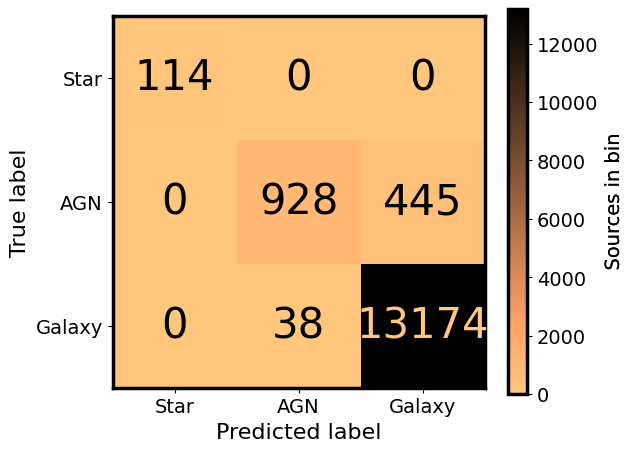

In [ ]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mat_seen,
                              display_labels=['Star', 'AGN', 'Galaxy'])


# NOTE: Fill all variables here with default values of the plot_confusion_matrix
disp_b = disp.plot(include_values=True,
                 cmap=cm.get_cmap('copper_r'), ax=ax1, xticks_rotation='horizontal')

for text_val in disp_b.text_.flatten():
    text_val.set_fontsize(30)
clb = plt.gca().images[-1].colorbar
clb.ax.tick_params(labelsize=14)
# clb.ax.ticklabel_format(style='sci', scilimits=(0, 0))
clb.outline.set_linewidth(2.5)
clb.ax.set_ylabel('Sources in bin', size=14, path_effects=pe2)

ax1.xaxis.get_label().set_fontsize(16)
ax1.yaxis.get_label().set_fontsize(16)

ax1.tick_params(axis='both', which='major', labelsize=14)

plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)

# fig.tight_layout()

plt.show()

In [ ]:
full_prediction_clf_df = pyc.predict_model(final_stacked_clf, data=full_prediction_reg_df)

In [ ]:
full_prediction_clf_df = full_prediction_clf_df.rename(columns={'Label': 'spec_class_pred', 'Score': 'spec_class_score'})

In [ ]:
full_prediction_clf_df.to_csv('RACS_SM_predicts_z_spec_class.csv')

In [ ]:
from google.colab import files

In [ ]:
files.download('model_final_RACS_SM_z.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('model_final_RACS_SM_class.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('./RACS_SM_predicts_z_spec_class.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!ls -lah

total 106M
drwxr-xr-x 1 root root 4.0K Jul 26 19:09 .
drwxr-xr-x 1 root root 4.0K Jul 26 16:32 ..
-rw-r--r-- 1 root root  14K Jul 26 16:34 condacolab_install.log
drwxr-xr-x 4 root root 4.0K Jul 16 13:19 .config
-rw-r--r-- 1 root root 185K Jul 26 19:09 logs.log
-rw-r--r-- 1 root root  17M Jul 26 19:07 model_final_RACS_SM_class.pkl
-rw-r--r-- 1 root root  59M Jul 26 17:57 model_final_RACS_SM_z.pkl
-rw-r--r-- 1 root root  26M Jul 26 19:09 RACS_SM_predicts_z_spec_class.csv
-rw-r--r-- 1 root root 5.6M Jul 15 03:07 RACS_VEXAS_ALLWISE_SM_specZ_milliquas_basicFeatures.csv.gz
drwxr-xr-x 4 root root 4.0K Jul 26 16:33 rapidsai-csp-utils
drwxr-xr-x 1 root root 4.0K Jul 16 13:20 sample_data
